# Welcome to Shape Classification

### Import all dependencies

In [1]:
pip install pydot==1.3.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphviz==0.10.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras import callbacks
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import Training data

In [4]:
DATASET_DIR = './shape-classification-dataset/shapes'

#### Check datasets from directory

In [5]:
os.listdir(DATASET_DIR)

['.DS_Store', 'square', 'triangle', 'star', 'circle']

#### Check total dataset

In [6]:
print('total circle images :', len(os.listdir(DATASET_DIR + '/circle')))
print('total square images :', len(os.listdir(DATASET_DIR + '/square')))
print('total star images :', len(os.listdir(DATASET_DIR + '/star')))
print('total triangle images :', len(os.listdir(DATASET_DIR + '/triangle')))

total circle images : 3720
total square images : 3765
total star images : 3765
total triangle images : 3720


#### Example data from dataset

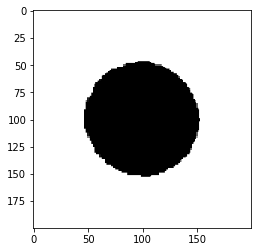

In [7]:
%matplotlib inline
img = image.load_img(DATASET_DIR + '/circle/0.png')
imgplot = plt.imshow(img)

### Preprocessing

#### Image Augmentation (Rescaling and Splitting)

In [8]:
train_dir = os.path.join(DATASET_DIR)
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.2) # set validation split

#### Generate for training and validation

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(16, 16),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(16, 16),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 11976 images belonging to 4 classes.
Found 2994 images belonging to 4 classes.


### Create the model

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(4, (3,3), activation='relu', input_shape=(16, 16, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    # Give output of 4 labels
    tf.keras.layers.Dense(4, activation='softmax')  
])

##### Create the loss and optimizer function

1. Adam Optimizer => replacement optimization algorithm for stochastic gradient descent 
2. metrics to benchmark is accuracy

In [11]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 4)         112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 4)           0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 196)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                3152      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 3

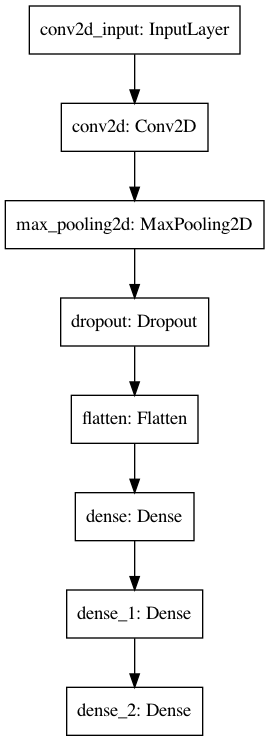

In [13]:
plot_model(model, to_file='submission_3_shape_classification.png')

### Create Callback

In [14]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nYour Accuracy >92%!")
      self.model.stop_training = True

In [15]:
callbacks = myCallback()

### Fit the model and Save the History

In [16]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/50
1497/1497 - 19s - loss: 0.6783 - accuracy: 0.6886 - val_loss: 0.2986 - val_accuracy: 0.8988
Epoch 2/50
1497/1497 - 19s - loss: 0.3830 - accuracy: 0.8365 - val_loss: 0.1558 - val_accuracy: 0.9549
Epoch 3/50
1497/1497 - 20s - loss: 0.2943 - accuracy: 0.8789 - val_loss: 0.0834 - val_accuracy: 0.9826
Epoch 4/50
1497/1497 - 18s - loss: 0.2300 - accuracy: 0.9098 - val_loss: 0.0556 - val_accuracy: 0.9850
Epoch 5/50

Your Accuracy >92%!
1497/1497 - 19s - loss: 0.1974 - accuracy: 0.9228 - val_loss: 0.0462 - val_accuracy: 0.9880


### Plotting

#### Plot Model Loss

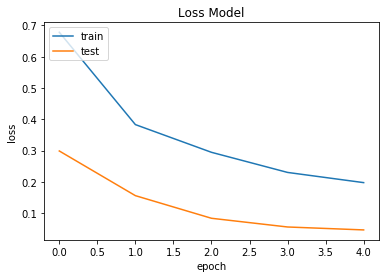

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot Model Accuracy

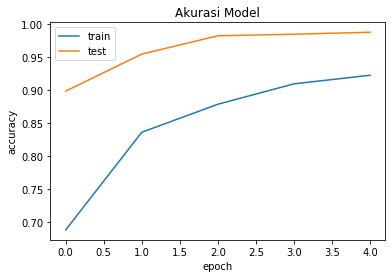

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Convert to Tensorflow Lite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [20]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)